In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 1024
nTime = 1024
lSim = 0
nSims = 1

phi0 = 1.; print('phi0 = ', phi0)
nu = 20
m2eff = 0.1
V0 = nu
lenLat = 100. / np.sqrt(V0); print('lenLat = ', lenLat)
phi_initial = 0
nCols = 2
V = lambda phi, lamb: V0*lamb/4.*( phi**2. - m2eff / lamb)**2.

nyq = nLat//2+1; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; print('dx, dk, spec ', dx, dk, spec)
alpha = 8.; dt = dx/alpha; dtout = dt*nLat/nTime; print('dtout/dt = ', dtout/dt)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)

phi0 =  1.0
lenLat =  22.360679774997894
dx, dk, spec  0.02183660134277138 0.28099258924162906 513
dtout/dt =  1.0
light_cone =  0


### Theoretical Field PS 

In [4]:
norm = lambda phi: 1./ phi / np.sqrt(lenLat)
freqs = dk * np.asarray(np.arange(1,nLat/2).tolist() + np.arange(-nLat/2,0).tolist())
omega = np.sqrt(freqs**2. + m2eff)
Filter = lambda sigma: np.exp(-0.5* (freqs*dx*sigma)**2.)

spectral_field = lambda phi, tem: norm(phi) * np.sqrt(2./(np.exp(omega/tem) - 1.)) / np.sqrt(2.*omega)
pspec = lambda phi, tem, sigma: np.abs(spectral_field(phi, tem) * Filter(sigma))**2.
sigma0_th = lambda phi, tem, sigma: np.sqrt(np.sum(pspec(phi, tem, sigma)))
list_thersholds_field_units = lambda phi, lam, tem, sigma: (np.asarray(list_threshold) - phi_initial) / sigma0_th(phi, lam, tem, sigma)

In [5]:
max(freqs)

143.58721310247245

In [6]:
sigma0_th(phi0, 1, 0.)

0.8420474546284193

### Extract data from files

In [7]:
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'

sim_location = lambda nT, nL, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/mexican_m2{:.4f}'.format(m2eff)+'_t'+str(nT)+'_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, tem: '_for_temp{:.4f}'.format(temp)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)

In [8]:
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))
list_thresh = lambda temp, sigma: np.arange(1, 500)/100*sigma0_th(temp, sigma)

def extract_sim(nT, nL, tem, phi, lam, sim, sigma=0.):
    data = np.genfromtxt(sim_location(nT, nL, tem, phi, lam, sim))
    simulation = [[]]*nCols
    for col in range(nCols):
        simulation[col] = np.reshape(data[:,col], (nT, nL))
    print(np.shape(simulation))
    if sigma != 0:
        for col in range(nCols):
            simulation[col] = np.asarray([smoothen(slic, sigma) for slic in simulation[col]])
    return np.asarray(simulation)

def find_peak_positions(slice, threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = scs.find_peaks(slice, height = threshold)[0].tolist()
    if slice[-1] >= threshold and slice[0] >= threshold and slice[-1] != slice[0]:
        if slice[0] > slice[-1] and slice[0] > slice[1]:
            peak_coord.append(0)
        elif slice[0] < slice[-1] and slice[-1] > slice[-2]:
            peak_coord.append(len(slice)-1) # this minds potential boundary discontinuities
    return np.asarray(peak_coord)

round_to_n = lambda x, n: x if x == 0 else round(x, -int(math.floor(math.log10(abs(x)))) + (n - 1))

In [9]:
list_lamb = [0.1]
list_temp = np.arange(10, 101, 5)/100.; print(list_temp)

filter_size = 0.

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.  ]


In [10]:
all_data = np.asarray([[[extract_sim(nTime, nLat, temp, phi0, lamb, sim, filter_size) for sim in range(lSim, nSims)] for lamb in list_lamb] for temp in list_temp])

(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)
(2, 1024, 1024)


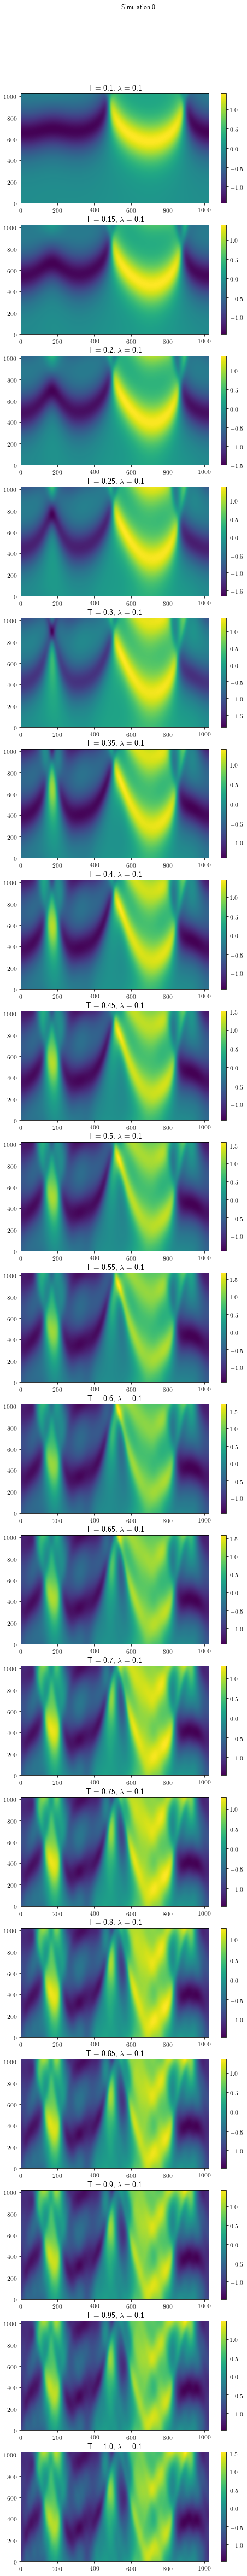

In [11]:
for sim in range(0, nSims, 1):
    fig, ax = plt.subplots(len(list_temp), 1, figsize = (4*1+4, 4*len(list_temp)))
    for temp in range(len(list_temp)):
        for lamb in range(len(list_lamb)):
            im0 = ax[temp].imshow(all_data[temp][lamb][sim][0], aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im0, ax = ax[temp])
            ax[temp].set_title('T = '+str(list_temp[temp])+f', $\lambda$ = '+str(list_lamb[lamb]))
    plt.suptitle('Simulation '+str(sim))
    plt.show()

In [12]:
omega = lambda k, m: k + m

lamb = 0
multiplier = 10
masses = np.asarray([[[[[0.]]*all_data.shape[3]]*all_data.shape[2]]*all_data.shape[1]]*all_data.shape[0])
print(masses.shape)
print(all_data.shape)
for temp in range(len(list_temp)):
    for lamb in range(len(list_lamb)):
        for sim in range(nSims-lSim):
            simulation = all_data[temp][lamb][sim]
            T, N = simulation.shape
                
            #cut_transition
            for t in range(len(simulation)):
                if (len(simulation[t][simulation[t] > np.sqrt(m2eff/list_lamb[lamb])]) > 0 or
                len(simulation[t][simulation[t] < - np.sqrt(m2eff/list_lamb[lamb])]) > 0):
                    tcut = t
                    break
#            fig, ax = plt.subplots(1, 1, figsize = (8, 4))
#            im = ax.imshow(simulation, aspect='auto', interpolation='none', origin='lower')
#            ax.plot(np.arange(N), np.ones(N)*tcut, 'r-')
#            plt.show()
            simulation = simulation[:tcut]

            pspec_sim = np.abs(np.fft.fftshift(np.fft.fft2(simulation)))**2.
            kk = np.fft.fftshift(np.fft.fftfreq(N,d=dx))*2*np.pi
            oo = np.fft.fftshift(np.fft.fftfreq(T,d=dtout))*2*np.pi

            maxVal = np.mean(pspec_sim) + multiplier*np.std(pspec_sim)
            osccoords = np.argwhere(pspec_sim > maxVal)
            popt, pcov = sco.curve_fit(omega, kk[osccoords[:,1]]**2., oo[osccoords[:,0]]**2.)
            masses[temp][lamb][sim] = popt[0]

#            if lamb == len(list_lamb)-1:
#                fig, ax = plt.subplots(1, 1, figsize = (8, 4))
#                ax.plot(kk, np.sqrt(omega(kk**2,*popt)), label='m=%5.5f'%popt[-1])
#                im = ax.imshow(pspec_sim, aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
#                ax.set_title('Simulation '+str(sim)+', $T = $'+str(list_temp[temp])+f', $\lambda = $'+str(list_lamb[lamb]))
#                plt.xlabel(r'$\bar{k}$'); plt.ylabel(r'$\bar{\omega_k}$')
#                #plt.xlim(-0.0002, 0.0002); plt.ylim(-0.00025, 0.00025)
#                #plt.xlim(-1,1); plt.ylim(-1,1)
#                plt.axvline(0, color='darkgray', ls='-.'); plt.axhline(0, color='darkgray', ls='-.')
#                plt.legend(); plt.show()

(19, 1, 1, 2, 1)
(19, 1, 1, 2, 1024, 1024)


ValueError: too many values to unpack (expected 2)

In [ ]:
line_fit = lambda x, a, b: a * x + b

colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
marks = cycle(('o', 'v', '*'))
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
mark = next(marks)
for lamb in range(len(list_lamb)):
    mean_masses = [np.mean(masses[typeP][temp][lamb]) for temp in range(len(list_temp))]
    popt, _ = sco.curve_fit(line_fit, list_temp, mean_masses)
    col = next(colors)
    plt.plot(list_temp, mean_masses, marker=mark, linestyle='None', color=col, label=f'$\lambda$ = '+str(list_lamb[lamb]))
    print(popt)
    plt.plot(list_temp, [line_fit(tem, *popt) for tem in list_temp], color=col)
    plt.ylabel(f'$m^2(T, \lambda)$')
    plt.xlabel(f'$T$')
plt.legend()
#plt.axhline(m2eff, color='darkgray', ls='-.')
plt.savefig(plots_file+'SSB_mass_distribution_with_temperature.pdf')
plt.show()

In [ ]:
for typeP in range(len(list_types)):
    colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
    marks = cycle(('o', 'v', '*'))
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    mark = next(marks)
    for temp in range(len(list_temp)):
        mean_masses = [np.mean(masses[typeP][temp][lamb]) for lamb in range(len(list_lamb))]
        popt, _ = sco.curve_fit(line_fit, list_lamb, mean_masses)
        col = next(colors)
        plt.plot(list_lamb, mean_masses, marker=mark, linestyle='None', color=col, label=f'$T$ = '+str(list_temp[temp]))
        plt.plot(list_lamb, line_fit(list_lamb, *popt), color=col)
        plt.ylabel(f'$m^2(T, \lambda)$')
        plt.xlabel(f'$\lambda$')
    plt.legend()
    plt.title(list_types[typeP]+' fluctuations')
#    plt.axhline(m2eff, color='darkgray', ls='-.')
    plt.savefig(plots_file+list_types[typeP]+'SB_mass_distribution_with_lambda.pdf')
    plt.show()